In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.data as data
import numpy as np
import torch
import torch.nn as nn
import time
import os.path as osp
import os
from utils.data_augumentation import (
    Compose,
    Scale,
    RandomRotation,
    RandomMirror,
    Resize,
    Normalize_Tensor,
)
import torch.utils.data as data
import json
import cv2
from statistics import mean, stdev
from sklearn.model_selection import train_test_split

In [26]:
cuda_num=0

In [27]:

def select_file_with_json(rootpath):
    """
    jsonファイルを参照してbutuと背景クラスのみが入っているファイルのみのファイル名をリスト化する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : file_names
        データへのパスを格納したリスト
    """
    json_dir = osp.join(rootpath, "json")
    json_tempate = osp.join(rootpath, "json")
    # print(json_dir)
    # print(osp.exists(json_dir))
    json_files = os.listdir(json_dir)
    filenames = []
    for json_file in json_files:
        path = osp.join(json_tempate, json_file)
        json_open = open(path, "r")
        json_load = json.load(json_open)
        shapes = json_load["shapes"]
        for shape in shapes:
            if shape["label"] != "butu":
                is_butu = False
                break
            is_butu = True
        if is_butu:
            filenames.append(json_file)
    # print(len(filenames))
    return filenames

def make_datapath_list(rootpath, filenames):
    """
    学習、検証の画像データとアノテーションデータのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """
    image_files = [
        osp.join(rootpath, "image", "%s.png" % os.path.splitext(filename)[0])
        for filename in filenames
    ]
    train_img_list = list()
    train_anno_list = list()
    val_img_list = list()
    val_anno_list = list()
    test_img_list = list()
    test_anno_list = list()
    annotate_files = [
        osp.join(
            rootpath, "SegmentationClassPNG", "%s.png" % os.path.splitext(filename)[0]
        )
        for filename in filenames
    ]
    # print(len(image_files))
    # print(image_files[0])
    # print(len(annotate_files))
    # print(annotate_files[0])
    num_train = len(image_files) * 8 // 10
    num_val = (len(image_files) - num_train) // 2
    num_test = len(image_files) - num_train - num_val
    # print(num_train, num_val, num_test)

    index = 0
    for image, anno in zip(image_files, annotate_files):
        if index < num_train:
            train_img_list.append(image)
            train_anno_list.append(anno)
        elif index < num_train + num_val:
            val_img_list.append(image)
            val_anno_list.append(anno)
        else:
            test_img_list.append(image)
            test_anno_list.append(anno)
        index += 1

    return (
        train_img_list,
        train_anno_list,
        val_img_list,
        val_anno_list,
        test_img_list,
        test_anno_list,
    )

def make_random_datapath_list(rootpath, filenames):
    """
    学習、検証の画像データとアノテーションデータのファイルパスリストをランダムに作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """
    img_path_list = [
        osp.join(rootpath, "image", "%s.png" % os.path.splitext(filename)[0])
        for filename in filenames
    ]
    anno_path_list = [
        osp.join(
            rootpath, "SegmentationClassPNG", "%s.png" % os.path.splitext(filename)[0]
        )
        for filename in filenames
    ]
    num_train = len(img_path_list) * 8 // 10
    num_val = (len(img_path_list) - num_train) // 2
    num_test = len(img_path_list) - num_train - num_val
    (tmp_img, test_img_list, tmp_anno, test_anno_list) = train_test_split(
        img_path_list,
        anno_path_list,
        train_size=num_train + num_val,
        test_size=num_test,
        shuffle=True,
        random_state=1,
    )

    (train_img_list, val_img_list, train_anno_list, val_anno_list) = train_test_split(
        tmp_img,
        tmp_anno,
        train_size=num_train,
        test_size=num_val,
        shuffle=True,
        random_state=1,
    )
    return (
        train_img_list,
        train_anno_list,
        val_img_list,
        val_anno_list,
        test_img_list,
        test_anno_list,
    )


class DataTransform:
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            "train": Compose(
                [
                    Scale(scale=[0.5, 1.5]),
                    RandomRotation(angle=[-10, 10]),
                    RandomMirror(),
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std),
                ]
            ),
            "val": Compose(
                [
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std),
                ]
            ),
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'val'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        """画像の枚数を返す"""
        return len(self.img_list)

    def __getitem__(self, index):
        """
        前処理をした画像のTensor形式のデータとアノテーションを取得
        """
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        """画像のTensor形式のデータ、アノテーションを取得する"""

        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)  # [高さ][幅]
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)  # [高さ][幅]
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

In [28]:
from unet_model import UNet

In [29]:
net = UNet(n_channels=1, n_classes=2)
state_dict = torch.load("./weights/Unet_v11000.pth",map_location={'cuda:'+str(cuda_num): 'cpu'})
net.load_state_dict(state_dict)
print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [30]:
rootpath = "../data/x3"
filenames = select_file_with_json(rootpath)
(
     _,
    _,
    _,
    _,
    test_img_list,
    test_anno_list,
) = make_datapath_list(rootpath, filenames)
color_mean = 0.18228737997050898
color_std = 0.15940997135888293
test_dataset = VOCDataset(test_img_list, test_anno_list, phase="val", transform=DataTransform(
input_size=475, color_mean=color_mean, color_std=color_std))

In [31]:
def show_detection(test_img_list,test_anno_list,test_dataset):
    """
    推論結果を表示する関数（緑:tp,赤:fp,青:fn）
    
    input:
        test_img_list
        test_anno_list
        test_dataset
    """
    time_all=0
    for index in range(len(test_img_list)):
        image_file_path = test_img_list[index]
        img_original = Image.open(image_file_path).convert(mode="RGB")   # [高さ][幅][色RGB]
        img_width, img_height = img_original.size
        anno_file_path = test_anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
        gt =Image.open(anno_file_path).convert('RGBA')
        p_palette = anno_class_img.getpalette()
        net.eval()
        img, anno_class_img = test_dataset.__getitem__(index)
        x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
        start = time.time()
        outputs = net(x)
        t = time.time() - start
        time_all+=t
        y = outputs
        y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
        y = np.argmax(y, axis=0)
        anno_class_img = Image.fromarray(np.uint8(y), mode="P")
        anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
        anno_class_img.putpalette(p_palette)
        anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換
        trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
        for x in range(img_width):
            for y in range(img_height):
                pixel = anno_class_img.getpixel((x, y))
                pixel_gt = gt.getpixel((x, y))
                if (pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0)and(pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0):
                    trans_img.putpixel((x, y), (0, 255,0, 200))
                elif pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0 :
                    trans_img.putpixel((x, y), (120, 0,0, 200))
                elif pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0:
                    trans_img.putpixel((x, y), (0, 0, 255, 200))
        result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
        plt.imshow(result)
        plt.show()
    print(time_all)

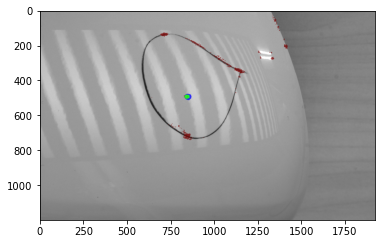

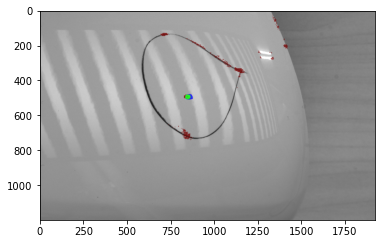

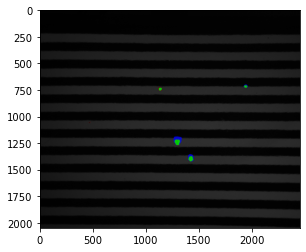

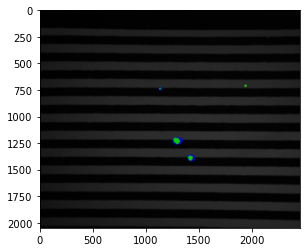

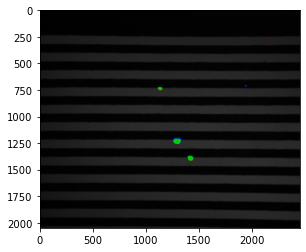

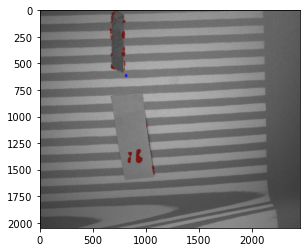

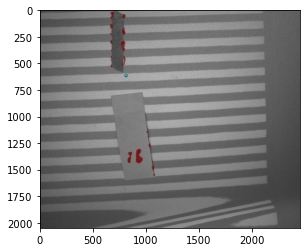

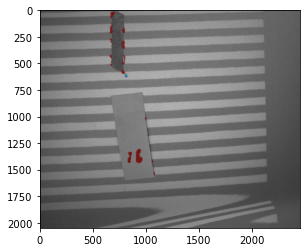

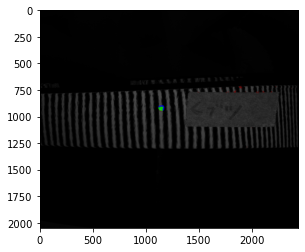

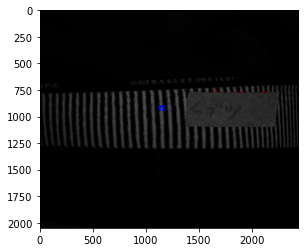

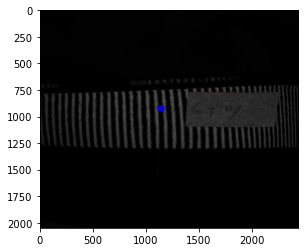

14.51577353477478


In [32]:
show_detection(test_img_list,test_anno_list,test_dataset)

In [33]:
def generate_true_pred(net,test_anno_list,test_dataset):
    """
    y_trueとy_predを出力する関数

    input: 
        anno_img:PIL.Image.Image image mode=RGB の推論データ情報のリスト
        anno_img_gt:PIL.Image.Image image mode=RGB のgtデータ情報のリスト
    return:
        y_true_list
        y_pred_list
    """
    y_true_list=[]
    y_pred_list=[]
    softmax=nn.Softmax(dim=1)
    for index,gt_path in enumerate(test_anno_list):
        gt = Image.open(gt_path)   # [高さ][幅]
        # p_palette = gt.getpalette()
        img_width, img_height = gt.size
        y_true=np.array(gt).flatten()
        y_true_list=np.hstack((y_true_list, y_true))
        img_475, _ = test_dataset.__getitem__(index)
        net.eval()
        x = img_475.unsqueeze(0)
        outputs = net(x)
        y = softmax(outputs)
        y = y[0].detach().numpy()
        y=y[1]
        detection = Image.fromarray(np.float32(y))
        detection = detection.resize((img_width, img_height), Image.NEAREST)
        # detection.putpalette(p_palette)
        y_pred=np.array(detection).flatten()
        y_pred_list=np.hstack((y_pred_list,y_pred))

    return y_true_list,y_pred_list

In [34]:
y_true_list,y_pred_list=generate_true_pred(net,test_anno_list,test_dataset)

[8.97386929e-04 8.97053229e-04 8.97053754e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.00000000e+00 9.99627725e-01 9.99627725e-01 ... 3.72274832e-04
 1.86137416e-04 0.00000000e+00]
[0.0011866  0.0011866  0.0011866  ... 0.99910229 0.99944997 0.9997493 ]


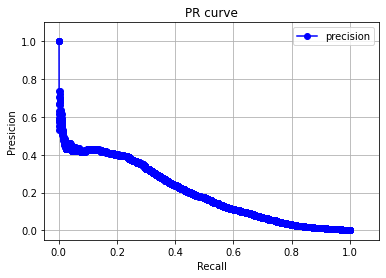

auc: 0.2038892331096514


In [35]:
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds = precision_recall_curve(y_true_list, y_pred_list)
print(precision)
print(recall)
print(thresholds)
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(recall, precision, "bo-", label="precision")
ax.legend()
plt.show()

# my_auc=(-1)*(np.diff(recall) * precision[1:]).sum()
# print("auc: "+str(my_auc))
print("auc: "+str(auc(recall,precision)))

/home/usrs/rin/miniconda3/envs/cuda_10.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  if sys.path[0] == '':


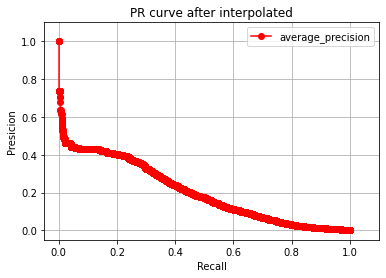

average_precision: 0.20575667373625753


In [36]:
modified_recall = np.concatenate([[1], recall, [0]])
modified_precision = np.concatenate([[0], precision, [0]])
modified_precision2 = np.maximum.accumulate(modified_precision)
average_precision = (-1)*(np.diff(modified_recall) * modified_precision2[1:]).sum()
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve after interpolated")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(modified_recall, modified_precision2, "bo-", label="average_precision",color='red')
ax.legend()
plt.show()
print("average_precision: "+str(auc(modified_recall, modified_precision2)))